<h1><center> Assignment 1 </center></h1>

[Libaries](#library)<br>
[Preprocess data](#preprocess)<br>
[Imputing](#imputing)<br>
[EDA](#eda)<br>
[Predict](#predict)<br>
[Conclude](#conclude)<br>

Research questions:
- Which of the 6/5/4 SDGS are more prevalent among the speeches given by countries in economic wealth groups (GDP per capita) 1, 2, 3, 4 ? 
- Predictive question: Based on a countries speeches can we predict how developed they are (Group 1, 2, 3, 4). Predictive question: Based on a countries speeches can we predict how developed they are (Group 1, 2, 3, 4). 

<h2><center>Libraries</center></h2>
<a id='library'></a>

In [95]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')
import string
from sklearn.feature_extraction.text import TfidfVectorizer
import re

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import missingno as msno

from sklearn.linear_model import LinearRegression

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/wowonl/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/wowonl/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wowonl/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/wowonl/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/wowonl/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


<h2><center>Load data and preprocess individual datasets</center></h2>
<a id='preprocess'></a>

<h3>Text data</h3>

In [96]:
sessions = np.arange(25, 80)
data=[]

for session in sessions:
    directory = "../data/UNGDC_1946-2024/TXT/Session "+str(session)+" - "+str(1945+session)
    # directory = f"./TXT/Session {session} - {1945+session}"
    for filename in os.listdir(directory):
        # f = open(os.path.join(directory, filename))
        with open(os.path.join(directory, filename)) as f:
            if filename[0]==".": #ignore hidden files
                continue
            splt = filename.split("_")
            data.append([session, 1945+session, splt[0], f.read()])

df_speech = pd.DataFrame(data, columns=['Session','Year','ISO-alpha3 Code','Speech'])
#country_speech = df_speech.set_index(['Year','ISO-alpha3 Code'])
country_speech = df_speech
country_speech.head()

df_speech.tail()

,Session,Year,ISO-alpha3 Code,Speech
9247,79,2024,CAF,"Mr President of the General Assembly, \nExcel..."
9248,79,2024,NPL,"Mr. President, \nYour Excellencies the Heads o..."
9249,79,2024,GTM,"- His Excellency Mr Philemon Yang, President o..."
9250,79,2024,BGD,"Mr. President, \n \nGood morning. \n \nLet m..."
9251,79,2024,PAK,"\n**Mr. President,** \n**Heads of State and G..."


In [97]:
def tokenize_speech(text):
    translator = str.maketrans("","",string.punctuation)
    text.translate(translator) #filter punctuation
    tokens = word_tokenize(text)
    sw = stopwords.words("english") #filter stopwords
    non_informative = ["we", "the", "i", "also", "united", "nation", "it"] #filter out non-informative words
    no_sw = []
    for w in tokens:
        w_lower = w.lower()
        if w not in sw and w_lower.isalpha() and w_lower not in non_informative:
            no_sw.append(w_lower)

    return no_sw

def lemmatize_speech(text): #lemmatize
    lemmatized = []
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in text]

    return ' '.join(lemmatized_tokens)
        

country_speech['Tokenized_speech'] = country_speech['Speech'].apply(tokenize_speech)
country_speech['Tokenized_lemmatized_speech'] = country_speech['Tokenized_speech'].apply(lemmatize_speech)
country_speech.head()

,Session,Year,ISO-alpha3 Code,Speech,Tokenized_speech,Tokenized_lemmatized_speech
0,25,1970,LBY,"110.\t Sir, allow me first to offer on behalf...","[sir, allow, first, offer, behalf, delegation,...",sir allow first offer behalf delegation libyan...
1,25,1970,KHM,4.\t Before I begin this speech I should like ...,"[before, begin, speech, like, first, behalf, d...",before begin speech like first behalf delegati...
2,25,1970,UKR,"130.\t Mr. President, I should like to offer ...","[president, like, offer, congratulations, hamb...",president like offer congratulation hambro ele...
3,25,1970,LKA,"176.\t Mr. President, the delegation of Ceylon...","[president, delegation, ceylon, personally, ha...",president delegation ceylon personally happy s...
4,25,1970,COL,"Mr. President, this visit to the United Nation...","[president, visit, nations, provides, opportun...",president visit nation provides opportunity co...


In [98]:
country_speech.info() # no nan values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9252 entries, 0 to 9251
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Session                      9252 non-null   int64 
 1   Year                         9252 non-null   int64 
 2   ISO-alpha3 Code              9252 non-null   object
 3   Speech                       9252 non-null   object
 4   Tokenized_speech             9252 non-null   object
 5   Tokenized_lemmatized_speech  9252 non-null   object
dtypes: int64(2), object(4)
memory usage: 433.8+ KB


<h3>Happinessdata</h3>

Merge first then impute

In [99]:
world_happiness_table = pd.read_excel("../data/DataForTable2.1.xls")
world_happiness_table.head()

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.723590,7.350416,0.450662,50.500000,0.718114,0.164055,0.881686,0.414297,0.258195
1,Afghanistan,2009,4.401778,7.508646,0.552308,50.799999,0.678896,0.187297,0.850035,0.481421,0.237092
2,Afghanistan,2010,4.758381,7.613900,0.539075,51.099998,0.600127,0.117861,0.706766,0.516907,0.275324
3,Afghanistan,2011,3.831719,7.581259,0.521104,51.400002,0.495901,0.160098,0.731109,0.479835,0.267175
4,Afghanistan,2012,3.782938,7.660506,0.520637,51.700001,0.530935,0.234157,0.775620,0.613513,0.267919


Merge happiness data with methodology to add country codes to happiness data

In [100]:
world_happiness_figure = pd.read_csv("../data/UNSD — Methodology.csv", delimiter=';')
world_happiness_figure = world_happiness_figure[['Country or Area', 'ISO-alpha3 Code']]
world_happiness_table = world_happiness_table.merge(world_happiness_figure, left_on='Country name', right_on='Country or Area', how='left')
world_happiness_table.drop('Country or Area', axis=1, inplace=True)

In [101]:
world_happiness_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2363 entries, 0 to 2362
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country name                      2363 non-null   object 
 1   year                              2363 non-null   int64  
 2   Life Ladder                       2363 non-null   float64
 3   Log GDP per capita                2335 non-null   float64
 4   Social support                    2350 non-null   float64
 5   Healthy life expectancy at birth  2300 non-null   float64
 6   Freedom to make life choices      2327 non-null   float64
 7   Generosity                        2282 non-null   float64
 8   Perceptions of corruption         2238 non-null   float64
 9   Positive affect                   2339 non-null   float64
 10  Negative affect                   2347 non-null   float64
 11  ISO-alpha3 Code                   2063 non-null   object 
dtypes: flo

In [102]:
#didnt match all the countries to iso3 codes so use Country Converter instead
world_happiness_table[world_happiness_table['ISO-alpha3 Code'].isnull()]['Country name'].value_counts()

Country name
Bolivia                      18
Vietnam                      18
Moldova                      18
Russia                       18
United Kingdom               18
United States                18
Tanzania                     18
Venezuela                    18
South Korea                  18
Netherlands                  17
Kosovo                       17
Taiwan Province of China     16
Iran                         16
Congo (Brazzaville)          14
Hong Kong S.A.R. of China    13
Ivory Coast                  12
Laos                         12
Congo (Kinshasa)             10
Syria                         7
Somaliland region             4
Name: count, dtype: int64

In [103]:
from country_converter import CountryConverter
cc = CountryConverter()
world_happiness_table["ISO-alpha3 Code"] = cc.pandas_convert(world_happiness_table["Country name"], to="ISO3")

Electricity, capita caloric supply, labor productivity

In [104]:
electricity = pd.read_csv('../data/access-to-electricity-vs-gdp-per-capita.csv')
caloric_supply = pd.read_csv('../data/daily-per-capita-caloric-supply.csv')
labor_productivity = pd.read_csv('../data/labor-productivity-per-hour-pennworldtable.csv')

<h3>Electricity</h3>

No electricity data for Taiwan and Kosovo

In [105]:
happiness_electric = pd.merge(
    left=world_happiness_table,
    right=electricity[['Code', 'Year', 'Access to electricity (% of population)']],
    how='left',
    left_on=['ISO-alpha3 Code', 'year'],
    right_on=['Code', 'Year']
)
happiness_electric.drop(['Code', 'Year'], axis='columns', inplace=True)
happiness_electric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2363 entries, 0 to 2362
Data columns (total 13 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Country name                             2363 non-null   object 
 1   year                                     2363 non-null   int64  
 2   Life Ladder                              2363 non-null   float64
 3   Log GDP per capita                       2335 non-null   float64
 4   Social support                           2350 non-null   float64
 5   Healthy life expectancy at birth         2300 non-null   float64
 6   Freedom to make life choices             2327 non-null   float64
 7   Generosity                               2282 non-null   float64
 8   Perceptions of corruption                2238 non-null   float64
 9   Positive affect                          2339 non-null   float64
 10  Negative affect                          2347 no

In [106]:
happiness_electric.head(3)

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,ISO-alpha3 Code,Access to electricity (% of population)
0,Afghanistan,2008,3.723590,7.350416,0.450662,50.500000,0.718114,0.164055,0.881686,0.414297,0.258195,AFG,42.4
1,Afghanistan,2009,4.401778,7.508646,0.552308,50.799999,0.678896,0.187297,0.850035,0.481421,0.237092,AFG,48.3
2,Afghanistan,2010,4.758381,7.613900,0.539075,51.099998,0.600127,0.117861,0.706766,0.516907,0.275324,AFG,42.7


In [107]:
#no electricity data for kosovo and taiwan, can't be imputed so delete whole country or don't use this dataset
happiness_electric[happiness_electric["Access to electricity (% of population)"].isnull()]

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,ISO-alpha3 Code,Access to electricity (% of population)
1100,Kosovo,2007,5.103906,NaN,0.847812,NaN,0.381364,NaN,0.894462,0.613723,0.236699,XKX,NaN
1101,Kosovo,2008,5.521660,8.858291,0.883843,NaN,NaN,0.093760,0.849059,0.499646,0.317828,XKX,NaN
1102,Kosovo,2009,5.891433,8.899382,0.830427,NaN,0.506415,0.202802,0.967839,0.527557,0.168830,XKX,NaN
1103,Kosovo,2010,5.176601,8.939567,0.707959,NaN,0.451444,0.170864,0.967272,0.672983,0.117717,XKX,NaN
1104,Kosovo,2011,4.859502,8.992258,0.759102,NaN,0.588979,0.003534,0.919212,0.603740,0.124438,XKX,NaN
1105,Kosovo,2012,5.639588,9.000282,0.757147,NaN,0.635793,0.027780,0.949651,0.561854,0.099630,XKX,NaN
1106,Kosovo,2013,6.125758,9.046240,0.720750,NaN,0.568463,0.114188,0.935095,0.649957,0.202731,XKX,NaN
1107,Kosovo,2014,5.000375,9.082124,0.705632,NaN,0.441391,0.009884,0.775201,0.551719,0.205950,XKX,NaN
1108,Kosovo,2015,5.077461,9.153252,0.805271,NaN,0.561048,0.177381,0.850647,0.684578,0.179989,XKX,NaN
1109,Kosovo,2016,5.759412,9.213440,0.823803,NaN,0.827399,0.120358,0.940898,0.588413,0.149607,XKX,NaN


In [108]:
happiness_electric = happiness_electric[happiness_electric['Access to electricity (% of population)'].notnull()]

Caloric supply

In [109]:
happiness_electric_caloric = pd.merge(
    left=happiness_electric,
    right=caloric_supply[['Code', 'Year', 'Daily calorie supply per person']],
    how='left',
    left_on=['ISO-alpha3 Code', 'year'],
    right_on=['Code', 'Year']
)
happiness_electric_caloric.drop(['Code', 'Year'], axis='columns', inplace=True)
happiness_electric_caloric.info()
#200 missing data values for calorie supply.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2330 entries, 0 to 2329
Data columns (total 14 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Country name                             2330 non-null   object 
 1   year                                     2330 non-null   int64  
 2   Life Ladder                              2330 non-null   float64
 3   Log GDP per capita                       2307 non-null   float64
 4   Social support                           2317 non-null   float64
 5   Healthy life expectancy at birth         2297 non-null   float64
 6   Freedom to make life choices             2295 non-null   float64
 7   Generosity                               2254 non-null   float64
 8   Perceptions of corruption                2205 non-null   float64
 9   Positive affect                          2306 non-null   float64
 10  Negative affect                          2314 no

Labor productivity

In [110]:
happiness_electric_caloric_labor = pd.merge(
    left=happiness_electric_caloric,
    right=labor_productivity[['Code', 'Year', 'Productivity: output per hour worked']],
    how='left',
    left_on=['ISO-alpha3 Code', 'year'],
    right_on=['Code', 'Year']
)
happiness_electric_caloric_labor.drop(['Code', 'Year'], axis='columns', inplace=True)
happiness_electric_caloric_labor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2330 entries, 0 to 2329
Data columns (total 15 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Country name                             2330 non-null   object 
 1   year                                     2330 non-null   int64  
 2   Life Ladder                              2330 non-null   float64
 3   Log GDP per capita                       2307 non-null   float64
 4   Social support                           2317 non-null   float64
 5   Healthy life expectancy at birth         2297 non-null   float64
 6   Freedom to make life choices             2295 non-null   float64
 7   Generosity                               2254 non-null   float64
 8   Perceptions of corruption                2205 non-null   float64
 9   Positive affect                          2306 non-null   float64
 10  Negative affect                          2314 no

In [111]:
happiness_electric_caloric

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,ISO-alpha3 Code,Access to electricity (% of population),Daily calorie supply per person
0,Afghanistan,2008,3.723590,7.350416,0.450662,50.500000,0.718114,0.164055,0.881686,0.414297,0.258195,AFG,42.4,2083.3438
1,Afghanistan,2009,4.401778,7.508646,0.552308,50.799999,0.678896,0.187297,0.850035,0.481421,0.237092,AFG,48.3,2099.3313
2,Afghanistan,2010,4.758381,7.613900,0.539075,51.099998,0.600127,0.117861,0.706766,0.516907,0.275324,AFG,42.7,2200.2148
3,Afghanistan,2011,3.831719,7.581259,0.521104,51.400002,0.495901,0.160098,0.731109,0.479835,0.267175,AFG,43.2,2171.8555
4,Afghanistan,2012,3.782938,7.660506,0.520637,51.700001,0.530935,0.234157,0.775620,0.613513,0.267919,AFG,69.1,2165.8926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2325,Zimbabwe,2019,2.693523,7.697755,0.759162,53.099998,0.631908,-0.050874,0.830652,0.658434,0.235354,ZWE,46.7,2038.3356
2326,Zimbabwe,2020,3.159802,7.596050,0.717243,53.575001,0.643303,0.002848,0.788523,0.660658,0.345736,ZWE,52.7,2035.4940
2327,Zimbabwe,2021,3.154578,7.656878,0.685151,54.049999,0.667636,-0.079007,0.756945,0.609917,0.241682,ZWE,49.0,2083.9954
2328,Zimbabwe,2022,3.296220,7.670073,0.666172,54.525002,0.651987,-0.072935,0.752632,0.640609,0.191350,ZWE,50.1,2072.4504


In [112]:
labor_productivity

,Entity,Code,Year,Productivity: output per hour worked
0,Argentina,ARG,1972,5.770799
1,Argentina,ARG,1973,6.049992
2,Argentina,ARG,1974,6.123540
3,Argentina,ARG,1975,6.015602
4,Argentina,ARG,1976,6.029272
...,...,...,...,...
3452,Vietnam,VNM,2015,4.946606
3453,Vietnam,VNM,2016,5.156925
3454,Vietnam,VNM,2017,5.652919
3455,Vietnam,VNM,2018,5.982665


In [113]:
happiness_electric_caloric_labor[happiness_electric_caloric_labor['Productivity: output per hour worked'].isnull()]['Country name'].value_counts().head(50)

Country name
Bolivia                   18
Cameroon                  18
El Salvador               18
Nicaragua                 18
Nepal                     18
Saudi Arabia              18
Senegal                   18
Ukraine                   18
Uganda                    18
Lebanon                   18
Moldova                   18
Jordan                    18
Kyrgyzstan                18
Kenya                     18
Kazakhstan                18
Georgia                   18
Zimbabwe                  18
Tanzania                  18
Tajikistan                18
Egypt                     18
Ghana                     18
Panama                    17
Zambia                    17
Honduras                  17
Paraguay                  17
Uzbekistan                17
Mali                      17
Armenia                   17
Burkina Faso              16
Albania                   16
Chad                      16
Azerbaijan                16
North Macedonia           16
Niger                     16
B

In [114]:
#productivity is not feasible so drop
happiness_electric_caloric_labor.drop(['Productivity: output per hour worked'], axis='columns', inplace=True)


In [115]:
happiness_electric_caloric_labor

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,ISO-alpha3 Code,Access to electricity (% of population),Daily calorie supply per person
0,Afghanistan,2008,3.723590,7.350416,0.450662,50.500000,0.718114,0.164055,0.881686,0.414297,0.258195,AFG,42.4,2083.3438
1,Afghanistan,2009,4.401778,7.508646,0.552308,50.799999,0.678896,0.187297,0.850035,0.481421,0.237092,AFG,48.3,2099.3313
2,Afghanistan,2010,4.758381,7.613900,0.539075,51.099998,0.600127,0.117861,0.706766,0.516907,0.275324,AFG,42.7,2200.2148
3,Afghanistan,2011,3.831719,7.581259,0.521104,51.400002,0.495901,0.160098,0.731109,0.479835,0.267175,AFG,43.2,2171.8555
4,Afghanistan,2012,3.782938,7.660506,0.520637,51.700001,0.530935,0.234157,0.775620,0.613513,0.267919,AFG,69.1,2165.8926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2325,Zimbabwe,2019,2.693523,7.697755,0.759162,53.099998,0.631908,-0.050874,0.830652,0.658434,0.235354,ZWE,46.7,2038.3356
2326,Zimbabwe,2020,3.159802,7.596050,0.717243,53.575001,0.643303,0.002848,0.788523,0.660658,0.345736,ZWE,52.7,2035.4940
2327,Zimbabwe,2021,3.154578,7.656878,0.685151,54.049999,0.667636,-0.079007,0.756945,0.609917,0.241682,ZWE,49.0,2083.9954
2328,Zimbabwe,2022,3.296220,7.670073,0.666172,54.525002,0.651987,-0.072935,0.752632,0.640609,0.191350,ZWE,50.1,2072.4504


<h2>Imputing</h2>
<a id='imputing'></a>

In [116]:
happiness_electric_caloric_labor.info() #lots of nan values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2330 entries, 0 to 2329
Data columns (total 14 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Country name                             2330 non-null   object 
 1   year                                     2330 non-null   int64  
 2   Life Ladder                              2330 non-null   float64
 3   Log GDP per capita                       2307 non-null   float64
 4   Social support                           2317 non-null   float64
 5   Healthy life expectancy at birth         2297 non-null   float64
 6   Freedom to make life choices             2295 non-null   float64
 7   Generosity                               2254 non-null   float64
 8   Perceptions of corruption                2205 non-null   float64
 9   Positive affect                          2306 non-null   float64
 10  Negative affect                          2314 no

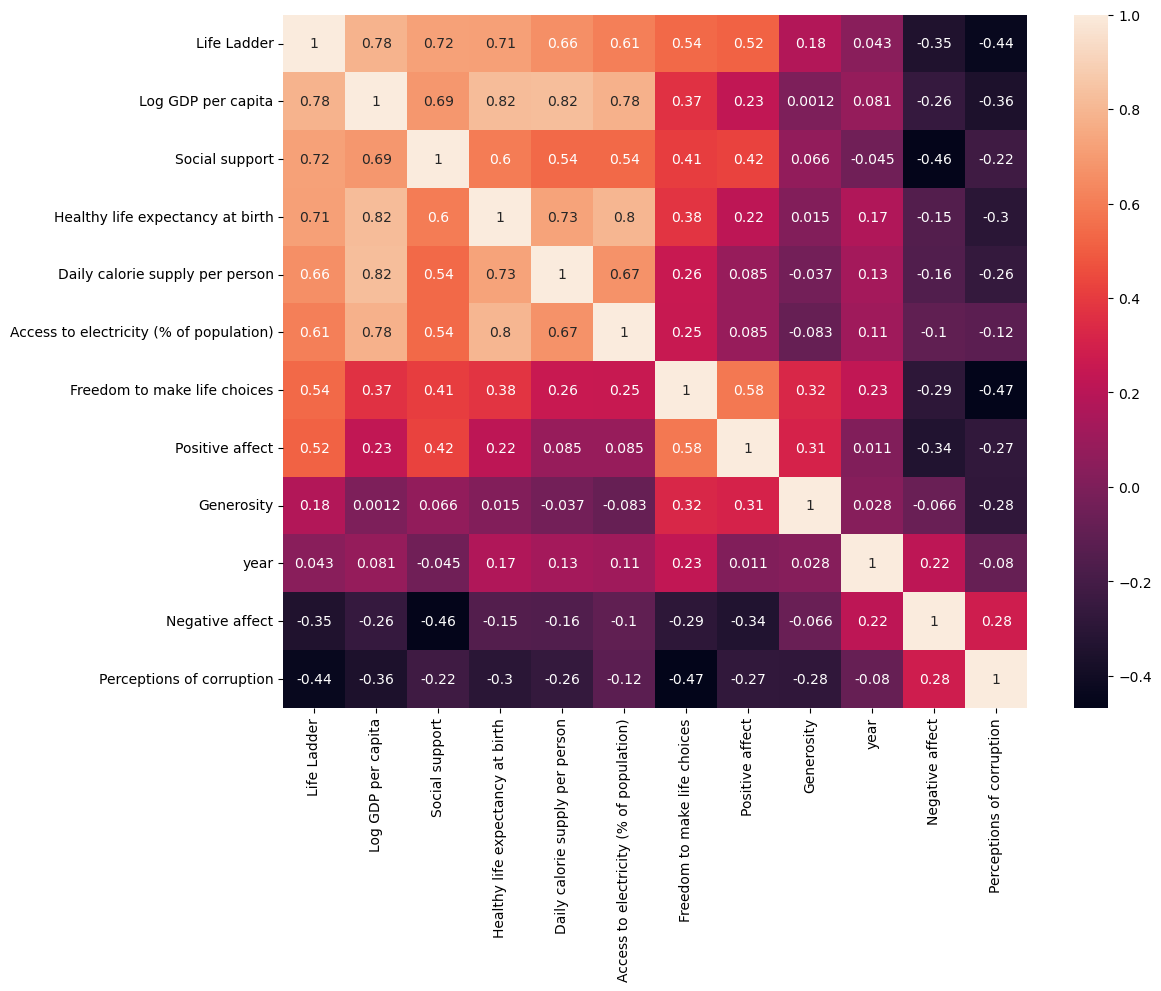

In [117]:
corrmat = happiness_electric_caloric_labor.corr(numeric_only=True)
f, ax = plt.subplots(figsize=(12, 9))
cols = corrmat.nlargest(15, 'Life Ladder')['Life Ladder'].index
cors = happiness_electric_caloric_labor[cols].corr()
sns.heatmap(cors, annot=True);

<Figure size 600x400 with 0 Axes>

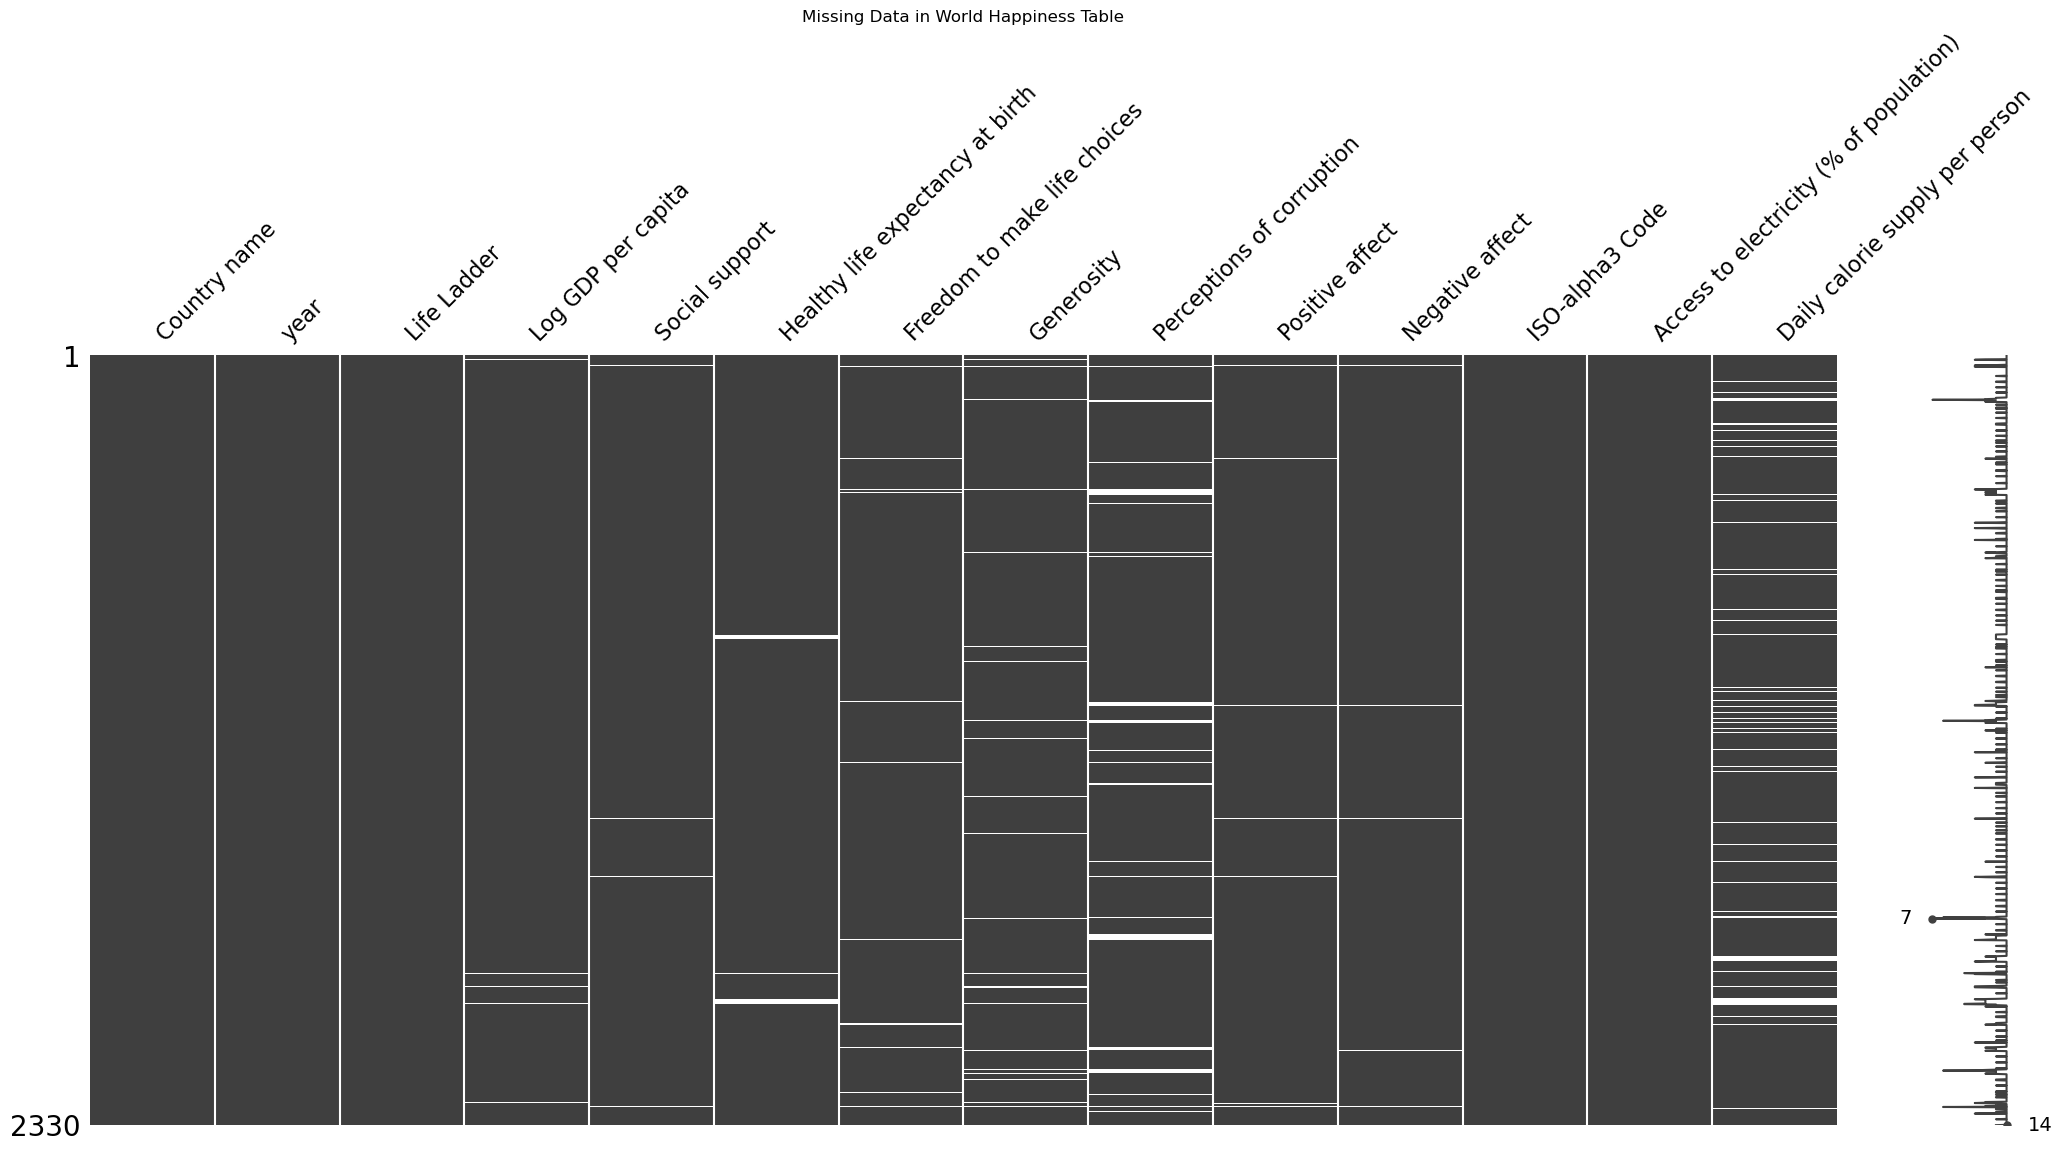

In [118]:
#nan values seem to happen at random make heatmap to make sure
plt.figure(figsize=(6,4))  # make the figure smaller
msno.matrix(happiness_electric_caloric_labor)
plt.title("Missing Data in World Happiness Table")
plt.show()

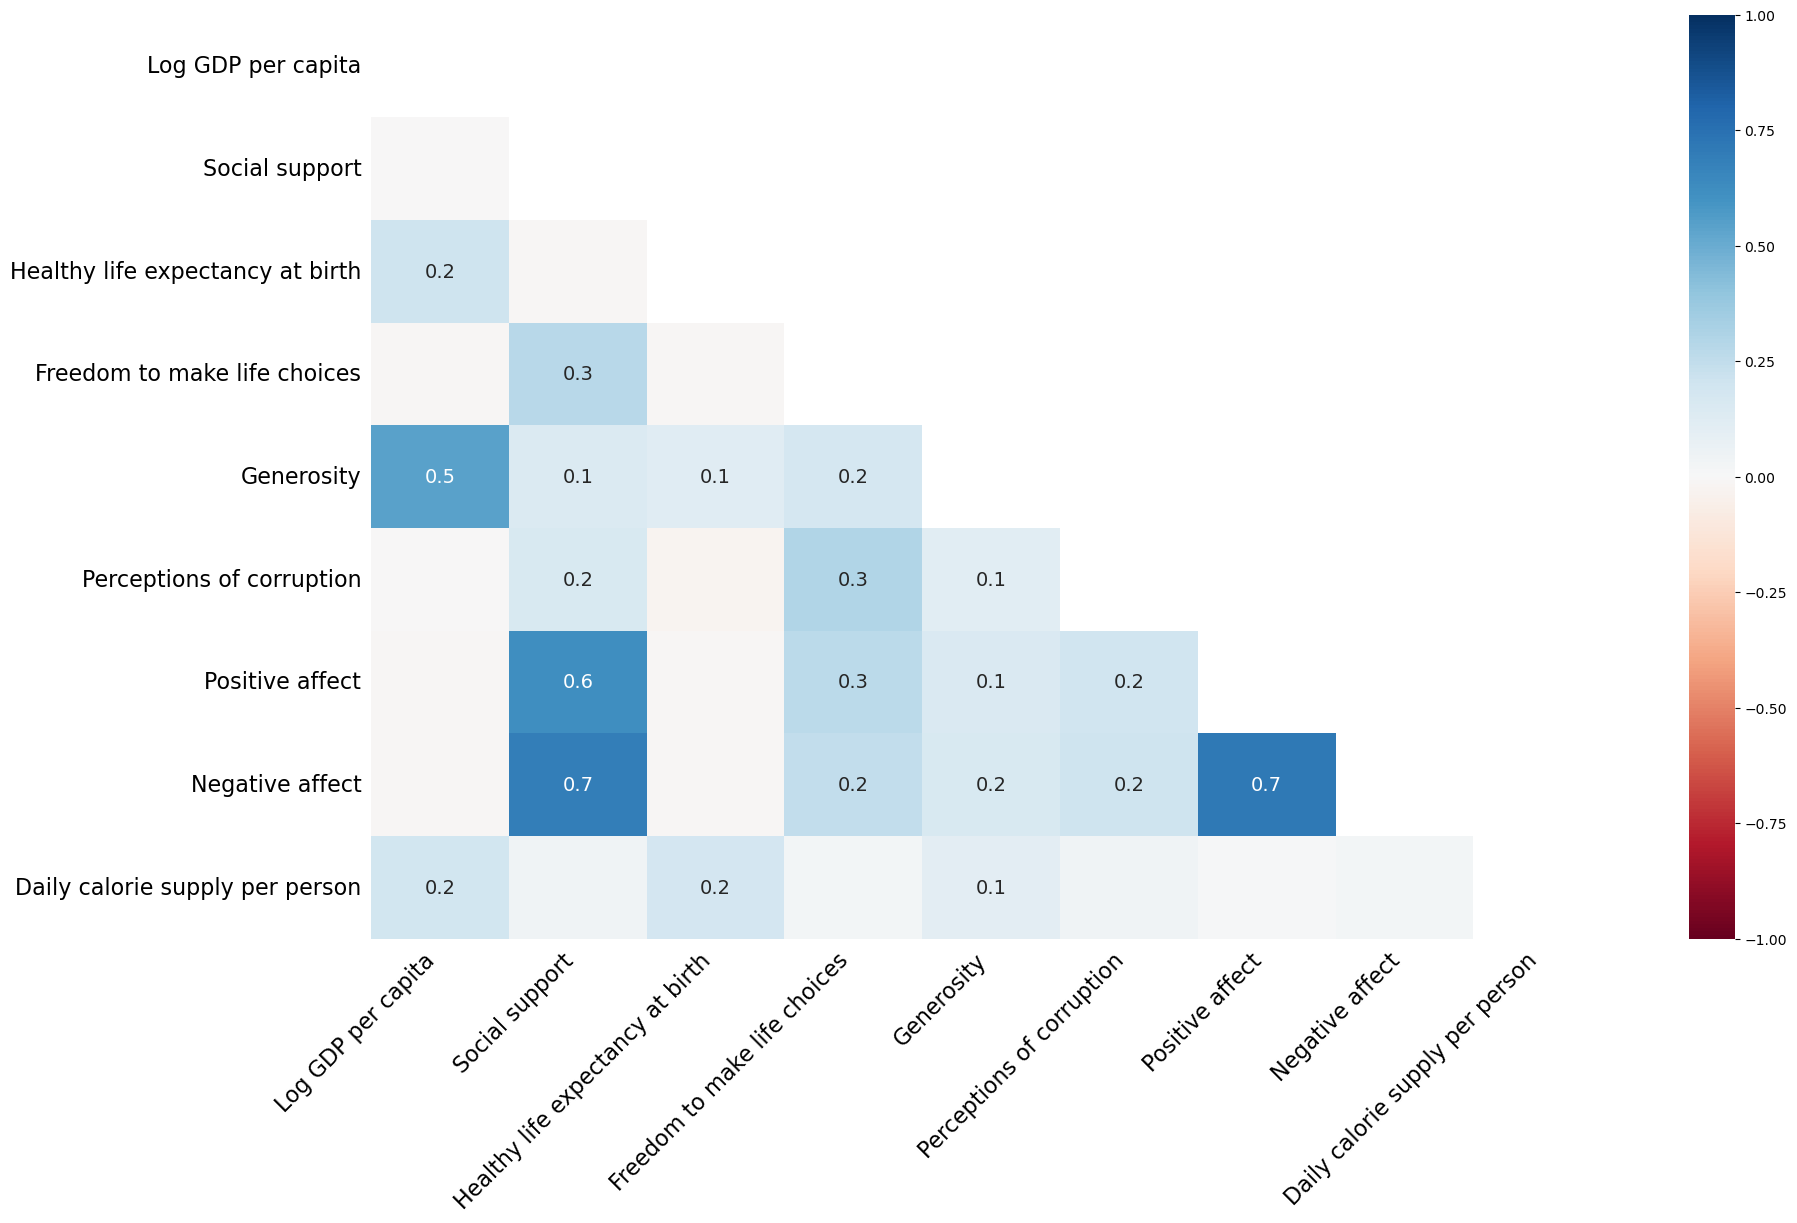

In [119]:
msno.heatmap(happiness_electric_caloric_labor); #only social support is strongly correlated with missing postive and negative affact data

Use 1 variable linear regression to impute the missing values for each column. Plot a histogram to impute the missing value with the column it has most correlation with. But they can't have overlapping NAN values on the same row, so check the heatmap above too!

In [120]:
world_happiness_clean = happiness_electric_caloric_labor.dropna().copy() #drop all nan values to train the regression or for imputing

In [121]:
# Impute Log GDP per capita with Linear regression using independent variable Life Ladder. Life expectancy has more correlation but overlapping nan values

model = LinearRegression(fit_intercept=True)
X = world_happiness_clean["Life Ladder"].values
Y = world_happiness_clean["Log GDP per capita"].values

model.fit(X[:, np.newaxis], Y)

to_predict = happiness_electric_caloric_labor[happiness_electric_caloric_labor["Log GDP per capita"].isnull()]["Life Ladder"].values
predicted_values = model.predict(to_predict[:, np.newaxis])

mask = happiness_electric_caloric_labor["Log GDP per capita"].isnull()
happiness_electric_caloric_labor.loc[mask, "Log GDP per capita"] = predicted_values

In [122]:
# Impute social support with Linear regression using independent variable Life Ladder.

model = LinearRegression(fit_intercept=True)
X = world_happiness_clean["Life Ladder"].values
Y = world_happiness_clean["Social support"].values

model.fit(X[:, np.newaxis], Y)

to_predict = happiness_electric_caloric_labor[happiness_electric_caloric_labor["Social support"].isnull()]["Life Ladder"].values
predicted_values = model.predict(to_predict[:, np.newaxis])

mask = happiness_electric_caloric_labor["Social support"].isnull()
happiness_electric_caloric_labor.loc[mask, "Social support"] = predicted_values

In [123]:
# Impute Healthy life expectancy at birth with Linear regression using independent variable Log GDP per capita.

model = LinearRegression(fit_intercept=True)
X = world_happiness_clean["Log GDP per capita"].values
Y = world_happiness_clean["Healthy life expectancy at birth"].values

model.fit(X[:, np.newaxis], Y)

to_predict = happiness_electric_caloric_labor[happiness_electric_caloric_labor["Healthy life expectancy at birth"].isnull()]["Log GDP per capita"].values
predicted_values = model.predict(to_predict[:, np.newaxis])

mask = happiness_electric_caloric_labor["Healthy life expectancy at birth"].isnull()
happiness_electric_caloric_labor.loc[mask, "Healthy life expectancy at birth"] = predicted_values

In [124]:
# Impute Freedom to make life choices with Linear regression using independent variable Life Ladder.

model = LinearRegression(fit_intercept=True)
X = world_happiness_clean["Life Ladder"].values
Y = world_happiness_clean["Freedom to make life choices"].values

model.fit(X[:, np.newaxis], Y)

to_predict = happiness_electric_caloric_labor[happiness_electric_caloric_labor["Freedom to make life choices"].isnull()]["Life Ladder"].values
predicted_values = model.predict(to_predict[:, np.newaxis])

mask = happiness_electric_caloric_labor["Freedom to make life choices"].isnull()
happiness_electric_caloric_labor.loc[mask, "Freedom to make life choices"] = predicted_values

In [125]:
# Impute Generosity with Linear regression using independent variable Freedom to make life choices.

model = LinearRegression(fit_intercept=True)
X = world_happiness_clean["Freedom to make life choices"].values
Y = world_happiness_clean["Generosity"].values

model.fit(X[:, np.newaxis], Y)

to_predict = happiness_electric_caloric_labor[happiness_electric_caloric_labor["Generosity"].isnull()]["Freedom to make life choices"].values
predicted_values = model.predict(to_predict[:, np.newaxis])

mask = happiness_electric_caloric_labor["Generosity"].isnull()
happiness_electric_caloric_labor.loc[mask, "Generosity"] = predicted_values

In [126]:
# Impute Perceptions of corruption with Linear regression using independent variable Freedom to make life choices.

model = LinearRegression(fit_intercept=True)
X = world_happiness_clean["Freedom to make life choices"].values
Y = world_happiness_clean["Perceptions of corruption"].values

model.fit(X[:, np.newaxis], Y)

to_predict = happiness_electric_caloric_labor[happiness_electric_caloric_labor["Perceptions of corruption"].isnull()]["Freedom to make life choices"].values
predicted_values = model.predict(to_predict[:, np.newaxis])

mask = happiness_electric_caloric_labor["Perceptions of corruption"].isnull()
happiness_electric_caloric_labor.loc[mask, "Perceptions of corruption"] = predicted_values

In [127]:
# Impute Positive affect with Linear regression using independent variable Freedom to make life choices.

model = LinearRegression(fit_intercept=True)
X = world_happiness_clean["Freedom to make life choices"].values
Y = world_happiness_clean["Positive affect"].values

model.fit(X[:, np.newaxis], Y)

to_predict = happiness_electric_caloric_labor[happiness_electric_caloric_labor["Positive affect"].isnull()]["Freedom to make life choices"].values
predicted_values = model.predict(to_predict[:, np.newaxis])

mask = happiness_electric_caloric_labor["Positive affect"].isnull()
happiness_electric_caloric_labor.loc[mask, "Positive affect"] = predicted_values

In [128]:
# Impute Negative affect" with Linear regression using independent variable Freedom to make life choices.

model = LinearRegression(fit_intercept=True)
X = world_happiness_clean["Social support"].values
Y = world_happiness_clean["Negative affect"].values

model.fit(X[:, np.newaxis], Y)

to_predict = happiness_electric_caloric_labor[happiness_electric_caloric_labor["Negative affect"].isnull()]["Social support"].values
predicted_values = model.predict(to_predict[:, np.newaxis])

mask = happiness_electric_caloric_labor["Negative affect"].isnull()
happiness_electric_caloric_labor.loc[mask, "Negative affect"] = predicted_values

In [129]:
# Impute Daily calorie supply with Linear regression using independent variable Log GDP per capita

model = LinearRegression(fit_intercept=True)
X = world_happiness_clean["Log GDP per capita"].values
Y = world_happiness_clean["Daily calorie supply per person"].values

model.fit(X[:, np.newaxis], Y)

to_predict = happiness_electric_caloric_labor[happiness_electric_caloric_labor["Daily calorie supply per person"].isnull()]["Log GDP per capita"].values
predicted_values = model.predict(to_predict[:, np.newaxis])

mask = happiness_electric_caloric_labor["Daily calorie supply per person"].isnull()
happiness_electric_caloric_labor.loc[mask, "Daily calorie supply per person"] = predicted_values

In [130]:
happiness_electric_caloric_labor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2330 entries, 0 to 2329
Data columns (total 14 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Country name                             2330 non-null   object 
 1   year                                     2330 non-null   int64  
 2   Life Ladder                              2330 non-null   float64
 3   Log GDP per capita                       2330 non-null   float64
 4   Social support                           2330 non-null   float64
 5   Healthy life expectancy at birth         2330 non-null   float64
 6   Freedom to make life choices             2330 non-null   float64
 7   Generosity                               2330 non-null   float64
 8   Perceptions of corruption                2330 non-null   float64
 9   Positive affect                          2330 non-null   float64
 10  Negative affect                          2330 no

In [131]:
happiness_electric_caloric_labor
country_speech

,Session,Year,ISO-alpha3 Code,Speech,Tokenized_speech,Tokenized_lemmatized_speech
0,25,1970,LBY,"110.\t Sir, allow me first to offer on behalf...","[sir, allow, first, offer, behalf, delegation,...",sir allow first offer behalf delegation libyan...
1,25,1970,KHM,4.\t Before I begin this speech I should like ...,"[before, begin, speech, like, first, behalf, d...",before begin speech like first behalf delegati...
2,25,1970,UKR,"130.\t Mr. President, I should like to offer ...","[president, like, offer, congratulations, hamb...",president like offer congratulation hambro ele...
3,25,1970,LKA,"176.\t Mr. President, the delegation of Ceylon...","[president, delegation, ceylon, personally, ha...",president delegation ceylon personally happy s...
4,25,1970,COL,"Mr. President, this visit to the United Nation...","[president, visit, nations, provides, opportun...",president visit nation provides opportunity co...
...,...,...,...,...,...,...
9247,79,2024,CAF,"Mr President of the General Assembly, \nExcel...","[mr, president, general, assembly, excellencie...",mr president general assembly excellency head ...
9248,79,2024,NPL,"Mr. President, \nYour Excellencies the Heads o...","[president, your, excellencies, heads, state, ...",president your excellency head state governmen...
9249,79,2024,GTM,"- His Excellency Mr Philemon Yang, President o...","[his, excellency, mr, philemon, yang, presiden...",his excellency mr philemon yang president sess...
9250,79,2024,BGD,"Mr. President, \n \nGood morning. \n \nLet m...","[president, good, morning, let, congratulate, ...",president good morning let congratulate electi...


In [132]:
happiness_electric_caloric_labor_speech = pd.merge(
    left=happiness_electric_caloric_labor,
    right=country_speech,
    how='left',
    left_on=['ISO-alpha3 Code', 'year'],
    right_on=['ISO-alpha3 Code', 'Year']
)
happiness_electric_caloric_labor_speech.drop(['year'], axis='columns', inplace=True)
happiness_electric_caloric_labor_speech.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2330 entries, 0 to 2329
Data columns (total 18 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Country name                             2330 non-null   object 
 1   Life Ladder                              2330 non-null   float64
 2   Log GDP per capita                       2330 non-null   float64
 3   Social support                           2330 non-null   float64
 4   Healthy life expectancy at birth         2330 non-null   float64
 5   Freedom to make life choices             2330 non-null   float64
 6   Generosity                               2330 non-null   float64
 7   Perceptions of corruption                2330 non-null   float64
 8   Positive affect                          2330 non-null   float64
 9   Negative affect                          2330 non-null   float64
 10  ISO-alpha3 Code                          2330 no

In [133]:
#remove these because they have no speeches
happiness_electric_caloric_labor_speech[happiness_electric_caloric_labor_speech['Speech'].isnull()]

,Country name,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,ISO-alpha3 Code,Access to electricity (% of population),Daily calorie supply per person,Session,Year,Speech,Tokenized_speech,Tokenized_lemmatized_speech
12,Afghanistan,2.436034,7.324501,0.454175,54.549999,0.394306,-0.084656,0.946299,0.178886,0.606713,AFG,97.7,2245.208700,NaN,NaN,NaN,NaN,NaN
13,Afghanistan,1.281271,6.046099,0.228217,54.875000,0.368377,-0.142437,0.733198,0.205868,0.575512,AFG,85.3,2273.896200,NaN,NaN,NaN,NaN,NaN
14,Afghanistan,1.445909,6.175889,0.368478,55.200001,0.228301,-0.194321,0.738471,0.260513,0.460167,AFG,85.3,1813.673679,NaN,NaN,NaN,NaN,NaN
340,Cameroon,5.037965,8.192780,0.646312,51.799999,0.791429,0.040916,0.868049,0.623713,0.346430,CMR,58.6,2806.571000,NaN,NaN,NaN,NaN,NaN
557,Djibouti,5.009330,8.115298,0.690440,53.639999,0.773457,0.123202,0.576098,0.740248,0.120192,DJI,57.4,2220.314200,NaN,NaN,NaN,NaN,NaN
559,Djibouti,5.005811,7.934187,0.772890,54.599998,0.763730,-0.072236,0.596910,0.662092,0.285635,DJI,57.9,2423.534200,NaN,NaN,NaN,NaN,NaN
846,Hong Kong S.A.R. of China,5.511187,10.746401,0.812178,70.320408,0.909820,0.149534,0.355985,0.591140,0.235955,HKG,100.0,3236.613300,NaN,NaN,NaN,NaN,NaN
847,Hong Kong S.A.R. of China,5.137262,10.815522,0.840222,70.673908,0.922211,0.290214,0.273945,0.575073,0.236634,HKG,100.0,3216.699700,NaN,NaN,NaN,NaN,NaN
848,Hong Kong S.A.R. of China,5.397056,10.788470,0.834716,70.535559,0.918026,0.301592,0.272125,0.606459,0.210104,HKG,100.0,3228.544200,NaN,NaN,NaN,NaN,NaN
849,Hong Kong S.A.R. of China,5.642835,10.846611,0.857314,70.832902,0.890418,0.325891,0.255775,0.600561,0.183106,HKG,100.0,3127.240200,NaN,NaN,NaN,NaN,NaN


In [134]:
final_df = happiness_electric_caloric_labor_speech[happiness_electric_caloric_labor_speech['Speech'].notnull()]
final_df.info()
final_df = final_df.set_index(['Year','ISO-alpha3 Code'])

<class 'pandas.core.frame.DataFrame'>
Index: 2292 entries, 0 to 2329
Data columns (total 18 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Country name                             2292 non-null   object 
 1   Life Ladder                              2292 non-null   float64
 2   Log GDP per capita                       2292 non-null   float64
 3   Social support                           2292 non-null   float64
 4   Healthy life expectancy at birth         2292 non-null   float64
 5   Freedom to make life choices             2292 non-null   float64
 6   Generosity                               2292 non-null   float64
 7   Perceptions of corruption                2292 non-null   float64
 8   Positive affect                          2292 non-null   float64
 9   Negative affect                          2292 non-null   float64
 10  ISO-alpha3 Code                          2292 non-nul

In [135]:
final_df

,,Country name,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Access to electricity (% of population),Daily calorie supply per person,Session,Speech,Tokenized_speech,Tokenized_lemmatized_speech
Year,ISO-alpha3 Code,,,,,,,,,,,,,,,,
2008.0,AFG,Afghanistan,3.723590,7.350416,0.450662,50.500000,0.718114,0.164055,0.881686,0.414297,0.258195,42.4,2083.343800,63.0,Since the last time we \ngathered here in this...,"[since, last, time, gathered, great, hall, pas...",since last time gathered great hall passed yea...
2009.0,AFG,Afghanistan,4.401778,7.508646,0.552308,50.799999,0.678896,0.187297,0.850035,0.481421,0.237092,48.3,2099.331300,64.0,"First, I would like to \ncongratulate His Exce...","[first, would, like, congratulate, his, excell...",first would like congratulate his excellency t...
2010.0,AFG,Afghanistan,4.758381,7.613900,0.539075,51.099998,0.600127,0.117861,0.706766,0.516907,0.275324,42.7,2200.214800,65.0,I join previous \nspeakers in congratulating y...,"[join, previous, speakers, congratulating, sir...",join previous speaker congratulating sir elect...
2011.0,AFG,Afghanistan,3.831719,7.581259,0.521104,51.400002,0.495901,0.160098,0.731109,0.479835,0.267175,43.2,2171.855500,66.0,I am honoured to be \nhere to read the stateme...,"[honoured, read, statement, president, his, ex...",honoured read statement president his excellen...
2012.0,AFG,Afghanistan,3.782938,7.660506,0.520637,51.700001,0.530935,0.234157,0.775620,0.613513,0.267919,69.1,2165.892600,67.0,"﻿As we speak today, the world\nis being shaken...","[speak, today, world, shaken, depravity, fanat...",speak today world shaken depravity fanatic com...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019.0,ZWE,Zimbabwe,2.693523,7.697755,0.759162,53.099998,0.631908,-0.050874,0.830652,0.658434,0.235354,46.7,2038.335600,74.0,Allow me to congratulate Mr. Tijjani Muhammad-...,"[allow, congratulate, tijjani, election, presi...",allow congratulate tijjani election president ...
2020.0,ZWE,Zimbabwe,3.159802,7.596050,0.717243,53.575001,0.643303,0.002848,0.788523,0.660658,0.345736,52.7,2035.494000,75.0,"Your Excellency, Ambassador Volkan Bozkir, Pre...","[your, excellency, ambassador, volkan, bozkir,...",your excellency ambassador volkan bozkir presi...
2021.0,ZWE,Zimbabwe,3.154578,7.656878,0.685151,54.049999,0.667636,-0.079007,0.756945,0.609917,0.241682,49.0,2083.995400,76.0,"Your Excellency Abdulla Shahid, President of t...","[your, excellency, abdulla, shahid, president,...",your excellency abdulla shahid president sessi...


<h2><center>Exploratory Data Analysis</center></h2>
<a id='eda'></a>

<h2><center>Predict</center></h2>
<a id='predict'></a>

<h2><center>Conclude</center></h2>
<a id='conclude'></a>